reserve()
confirmArrival()
finalizeNoShow()

 LATENCY STATISTICS
reserve {'mean': np.float64(1.8445182991027833), 'median': np.float64(1.7106351852416992), 'p95': np.float64(2.3192938804626464), 'p99': np.float64(3.4510352540016163), 'variance': np.float64(0.15542057852796515)}
confirmArrival {'mean': np.float64(1.7854940223693847), 'median': np.float64(1.767120361328125), 'p95': np.float64(2.2624900698661805), 'p99': np.float64(2.4867776393890373), 'variance': np.float64(0.05464356723658975)}
finalizeNoShow {'mean': np.float64(1.786379747390747), 'median': np.float64(1.7098865509033203), 'p95': np.float64(2.327574276924133), 'p99': np.float64(2.544912102222442), 'variance': np.float64(0.08288264585240096)}


C:\Users\chaym\AppData\Local\Temp\ipykernel_12148\3969947510.py:146: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(latencies.values(), labels=latencies.keys())


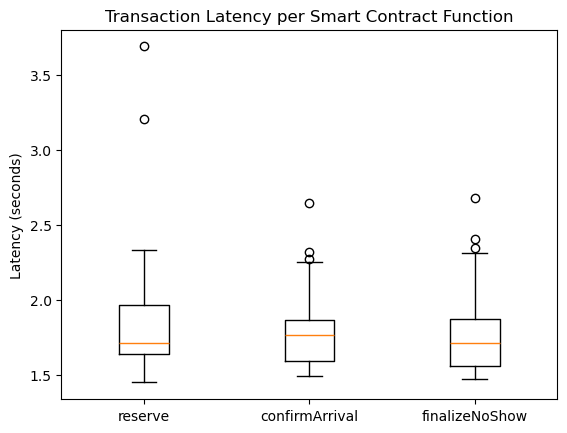

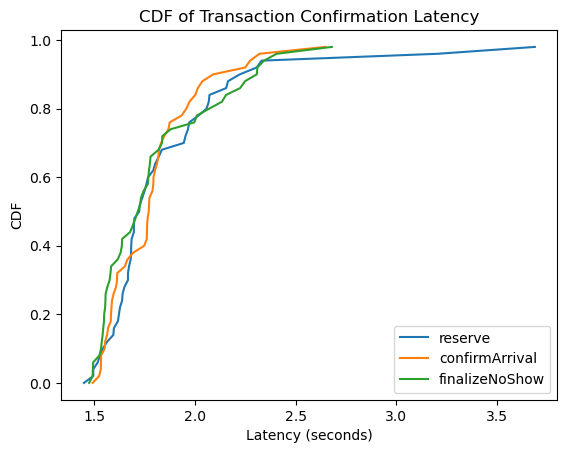

In [ ]:
from web3 import Web3
import time
import csv
import numpy as np
import matplotlib.pyplot as plt

# ===============================
# CONFIG
# ===============================

RPC_URL = "https://json-rpc.evm.testnet.iota.cafe"

PRIVATE_KEY = ""
ACCOUNT = Web3.to_checksum_address("")

CONTRACT_ADDRESS = Web3.to_checksum_address(
    ""
)

SMART_CONTRACT_ABI = [
    {
        "inputs": [{"internalType": "string", "name": "slot", "type": "string"}],
        "name": "reserve",
        "outputs": [{"internalType": "uint256", "name": "id", "type": "uint256"}],
        "stateMutability": "payable",
        "type": "function",
    },
    {
        "inputs": [{"internalType": "uint256", "name": "id", "type": "uint256"}],
        "name": "confirmArrival",
        "outputs": [],
        "stateMutability": "nonpayable",
        "type": "function",
    },
    {
        "inputs": [{"internalType": "uint256", "name": "id", "type": "uint256"}],
        "name": "finalizeNoShow",
        "outputs": [],
        "stateMutability": "nonpayable",
        "type": "function",
    },
]

N_RUNS = 50   
GAS = 350000

# WEB3 INIT

w3 = Web3(Web3.HTTPProvider(RPC_URL))

contract = w3.eth.contract(
    address=CONTRACT_ADDRESS,
    abi=SMART_CONTRACT_ABI
)

nonce = w3.eth.get_transaction_count(ACCOUNT)

# CSV LOG
csv_file = open("latency_results.csv", "w", newline="")
writer = csv.writer(csv_file)
writer.writerow(["function", "latency_sec"])

def send_tx(fn, value=0):
    global nonce

    tx = fn.build_transaction({
        "from": ACCOUNT,
        "nonce": nonce,
        "gas": GAS,
        "gasPrice": w3.to_wei("10", "gwei"),
        "value": value,
    })

    signed = w3.eth.account.sign_transaction(tx, PRIVATE_KEY)

    t_sent = time.time()
    tx_hash = w3.eth.send_raw_transaction(signed.rawTransaction)

    receipt = w3.eth.wait_for_transaction_receipt(tx_hash)
    t_mined = time.time()

    nonce += 1

    return t_mined - t_sent


# ===============================
# TESTS DE LATENCE
# ===============================

latencies = {
    "reserve": [],
    "confirmArrival": [],
    "finalizeNoShow": []
}

print("reserve()")

for i in range(N_RUNS):
    slot = f"SLOT_{i}"
    latency = send_tx(
        contract.functions.reserve(slot),
        value=w3.to_wei(1, "ether")
    )
    latencies["reserve"].append(latency)
    writer.writerow(["reserve", latency])
    time.sleep(1)

print("confirmArrival()")

for i in range(1, N_RUNS + 1):
    latency = send_tx(contract.functions.confirmArrival(i))
    latencies["confirmArrival"].append(latency)
    writer.writerow(["confirmArrival", latency])
    time.sleep(1)

print("finalizeNoShow()")

for i in range(1, N_RUNS + 1):
    latency = send_tx(contract.functions.finalizeNoShow(i))
    latencies["finalizeNoShow"].append(latency)
    writer.writerow(["finalizeNoShow", latency])
    time.sleep(1)

csv_file.close()

# STATISTICS

def stats(x):
    return {
        "mean": np.mean(x),
        "median": np.median(x),
        "p95": np.percentile(x, 95),
        "p99": np.percentile(x, 99),
        "variance": np.var(x)
    }

print("\n LATENCY STATISTICS")
for k, v in latencies.items():
    print(k, stats(v))

# FIGURES

# --- Boxplot
plt.figure()
plt.boxplot(latencies.values(), labels=latencies.keys())
plt.title("Transaction Latency per Smart Contract Function")
plt.ylabel("Latency (seconds)")
plt.show()

# --- CDF
plt.figure()
for name, values in latencies.items():
    data = np.sort(values)
    cdf = np.arange(len(data)) / len(data)
    plt.plot(data, cdf, label=name)

plt.xlabel("Latency (seconds)")
plt.ylabel("CDF")
plt.title("CDF of Transaction Confirmation Latency")
plt.legend()
plt.show()


In [10]:
import pandas as pd


N_RUNS = 50
GAS_LIMIT = 400000
GAS_PRICE_GWEI = 10

# ===============================
# WEB3 INIT
# ===============================

w3 = Web3(Web3.HTTPProvider(RPC_URL))

contract = w3.eth.contract(
    address=CONTRACT_ADDRESS,
    abi=SMART_CONTRACT_ABI
)

nonce = w3.eth.get_transaction_count(ACCOUNT)

# ===============================
# CSV LOG
# ===============================

rows = []

def send_tx(fn, value=0):
    global nonce

    tx = fn.build_transaction({
        "from": ACCOUNT,
        "nonce": nonce,
        "gas": GAS_LIMIT,
        "gasPrice": w3.to_wei(GAS_PRICE_GWEI, "gwei"),
        "value": value,
    })

    signed = w3.eth.account.sign_transaction(tx, PRIVATE_KEY)
    tx_hash = w3.eth.send_raw_transaction(signed.rawTransaction)

    receipt = w3.eth.wait_for_transaction_receipt(tx_hash)

    nonce += 1
    time.sleep(1)

    return receipt.gasUsed


# ===============================
# EXPERIMENTS
# ===============================

gas_data = {
    "reserve": [],
    "confirmArrival": [],
    "finalizeNoShow": []
}

print("reserve()")
for i in range(N_RUNS):
    gas = send_tx(
        contract.functions.reserve(f"SLOT_{i}"),
        value=w3.to_wei(1, "ether")
    )
    gas_data["reserve"].append(gas)

print("confirmArrival()")
for i in range(1, N_RUNS + 1):
    gas = send_tx(contract.functions.confirmArrival(i))
    gas_data["confirmArrival"].append(gas)

print("finalizeNoShow()")
for i in range(1, N_RUNS + 1):
    gas = send_tx(contract.functions.finalizeNoShow(i))
    gas_data["finalizeNoShow"].append(gas)

# ===============================
# STATISTICS
# ===============================

summary = []

for fn, values in gas_data.items():
    summary.append({
        "Function": fn,
        "Gas_min": int(np.min(values)),
        "Gas_mean": int(np.mean(values)),
        "Gas_max": int(np.max(values)),
        "Cost_IOTA": np.mean(values) * w3.to_wei(GAS_PRICE_GWEI, "gwei") / 1e18
    })

df = pd.DataFrame(summary)
print(df)

df.to_csv("gas_evaluation.csv", index=False)


reserve()
confirmArrival()
finalizeNoShow()
         Function  Gas_min  Gas_mean  Gas_max  Cost_IOTA
0         reserve    22860     22869    22872   0.000229
1  confirmArrival    22257     22257    22257   0.000223
2  finalizeNoShow    22259     22259    22259   0.000223


In [13]:
w3 = Web3(Web3.HTTPProvider(RPC_URL))
contract = w3.eth.contract(address=CONTRACT_ADDRESS, abi=SMART_CONTRACT_ABI)

nonce = w3.eth.get_transaction_count(ACCOUNT)

def send(fn, value=0):
    global nonce
    tx = fn.build_transaction({
        "from": ACCOUNT,
        "nonce": nonce,
        "gas": 300000,
        "gasPrice": w3.to_wei(15, "gwei"),
        "value": value,
    })

    signed = w3.eth.account.sign_transaction(tx, PRIVATE_KEY)

    try:
        tx_hash = w3.eth.send_raw_transaction(signed.rawTransaction)
        receipt = w3.eth.wait_for_transaction_receipt(tx_hash)
        nonce += 1
        return receipt.status == 1
    except Exception as e:
        nonce += 1
        return False


# ===============================
# TESTS
# ===============================

results = {}

print("Double reservation")
ok1 = send(contract.functions.reserve("A1"), value=w3.to_wei(1, "ether"))
ok2 = send(contract.functions.reserve("A1"), value=w3.to_wei(1, "ether"))
results["double_reservation"] = (ok1 is True and ok2 is False)

print("Confirmation without reservation")
results["confirm_without_reservation"] = not send(
    contract.functions.confirmArrival(999)
)

print("NoShow before deadline")
results["early_no_show"] = not send(
    contract.functions.finalizeNoShow(1)
)

print(" Double confirmation")
ok3 = send(contract.functions.confirmArrival(1))
ok4 = send(contract.functions.confirmArrival(1))
results["double_confirmation"] = (ok3 is True and ok4 is False)

# ===============================
# RESULTS
# ===============================

print("\nLOGICAL SECURITY RESULTS")
for k, v in results.items():
    print(k, "→", "REJECTED " if v else "FAILED ")


Double reservation
Confirmation without reservation
NoShow before deadline
 Double confirmation

LOGICAL SECURITY RESULTS
double_reservation → REJECTED 
confirm_without_reservation → REJECTED 
early_no_show → REJECTED 
double_confirmation → FAILED 
